In [6]:
import pandas, numpy, seaborn
import scipy, scipy.stats
import matplotlib, matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':10, 'figure.figsize':(12, 8)})

In [7]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/1)data_input/'
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

In [8]:
%%time
# DL data ATG7 isoform expression
path = input_file_directory + "/mef_jc10/exp1/shake"
red_path = '/jc10_exp1_red_shake.csv'
green_path = '/jc10_exp1_green_shake.csv'

df_aggregates= pandas.read_csv(path+red_path, sep = ";")
df_aggregates = df_aggregates.apply(lambda x: x.str.replace(',','.'))


df_monomeric= pandas.read_csv(path+green_path, sep = ";")
df_monomeric = df_monomeric.apply(lambda x: x.str.replace(',','.'))

print(df_aggregates)

  Unnamed: 0 Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4 Unnamed: 5  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1  condition     normal         ev     ev_dox        wt1       vsr1   
2       DMSO     20.097     19.325     19.393     19.575     19.448   
3  DMSO+FCCP     19.905     19.067     19.051     18.769     18.426   
4  DMSO+FCCP     19.533     19.118      18.78     18.558     18.707   
5  DMSO+FCCP     19.287     20.347     19.603     20.578     15.905   
6        BAF     20.846     20.268     21.232     20.037     20.733   
7   BAF+FCCP     19.906     19.952     19.365     19.494      19.12   
8   BAF+FCCP     19.376     18.825     19.479     20.059     20.595   
9   BAF+FCCP     19.436     19.606     19.941     20.215     19.691   

  Unnamed: 6 Unnamed: 7  
0        NaN        NaN  
1        wt2       vsr2  
2     19.467     18.489  
3     19.121     19.413  
4     18.394     19.017  
5     19.192     18.912  
6     20.622     20.761  
7     20.2

In [9]:
dfs = df_aggregates, df_monomeric
for df in dfs:
    #select column name and index label
    df.columns = df.iloc[1]
    df.columns.name = None 
    #drop the first useless rows + dmso/baf, positive control for FCCP
    df.drop(df.index[0:3], inplace = True)
    df.drop(df.index[3], inplace = True)
    #reset index
    df.reset_index(drop = True, inplace = True)

#to numeric
df_monomeric.iloc[:,1:8] = df_monomeric.iloc[:,1:8].apply(pandas.to_numeric, errors='coerce', axis=1)
df_aggregates.iloc[:,1:8] = df_aggregates.iloc[:,1:8].apply(pandas.to_numeric, errors='coerce', axis=1)
df_aggregates

,condition,normal,ev,ev_dox,wt1,vsr1,wt2,vsr2
0,DMSO+FCCP,19.905,19.067,19.051,18.769,18.426,19.121,19.413
1,DMSO+FCCP,19.533,19.118,18.78,18.558,18.707,18.394,19.017
2,DMSO+FCCP,19.287,20.347,19.603,20.578,15.905,19.192,18.912
3,BAF+FCCP,19.906,19.952,19.365,19.494,19.12,20.283,20.044
4,BAF+FCCP,19.376,18.825,19.479,20.059,20.595,19.662,19.3
5,BAF+FCCP,19.436,19.606,19.941,20.215,19.691,20.053,20.875


In [10]:
#create dataframe for ratio
df_ratio = df_aggregates.copy()
df_ratio.drop(df_ratio.columns[1:], axis = 1, inplace = True)
df_ratio = df_ratio.assign(condition = df_monomeric['condition'],
                           normal= df_monomeric['normal'] / df_aggregates['normal'],
                           ev= df_monomeric['ev'] / df_aggregates['ev'],
                           ev_dox= df_monomeric['ev_dox'] / df_aggregates['ev_dox'],
                           wt1= df_monomeric['wt1'] / df_aggregates['wt1'],
                           vsr1= df_monomeric['vsr1'] / df_aggregates['vsr1'],
                           wt2= df_monomeric['wt2'] / df_aggregates['wt2'],
                           vsr2= df_monomeric['vsr2'] / df_aggregates['vsr2'])
df_ratio

,condition,normal,ev,ev_dox,wt1,vsr1,wt2,vsr2
0,DMSO+FCCP,2.43924,2.44842,2.48055,2.50621,2.49631,2.55609,2.32525
1,DMSO+FCCP,2.24804,2.26901,2.49989,2.3218,2.29176,2.38192,2.31093
2,DMSO+FCCP,2.25276,2.39854,2.42407,2.45068,2.41773,2.49734,2.36622
3,BAF+FCCP,2.82282,2.90562,2.83522,2.90366,3.02631,3.03205,2.99267
4,BAF+FCCP,2.89497,2.99368,2.90528,2.85573,2.74139,3.09221,2.82979
5,BAF+FCCP,2.89056,2.68469,2.75623,2.70848,2.70535,2.74592,2.75257


findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


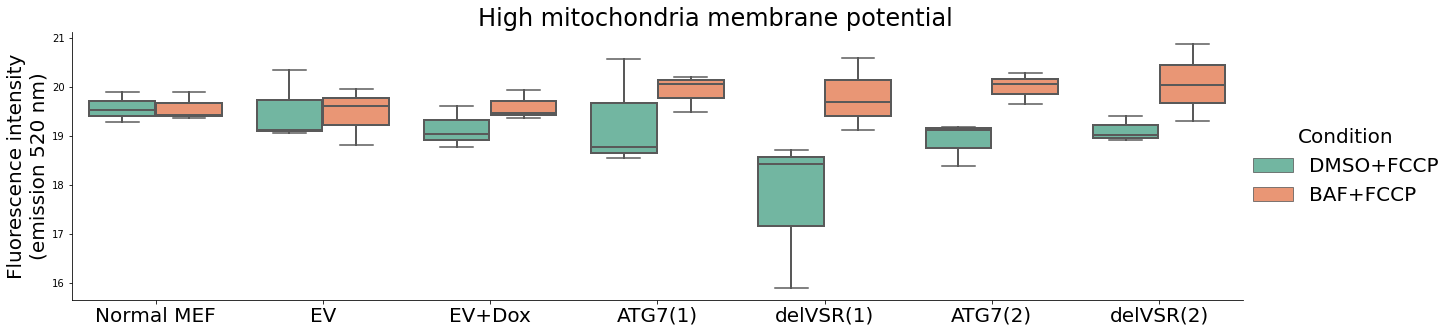

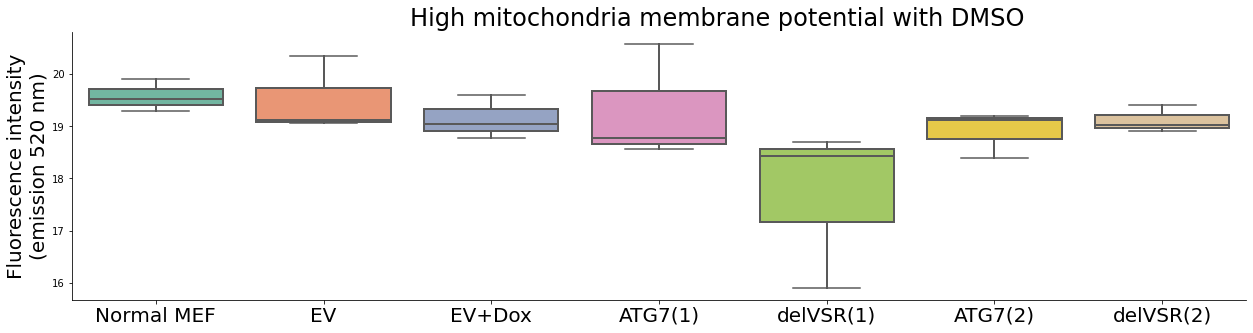

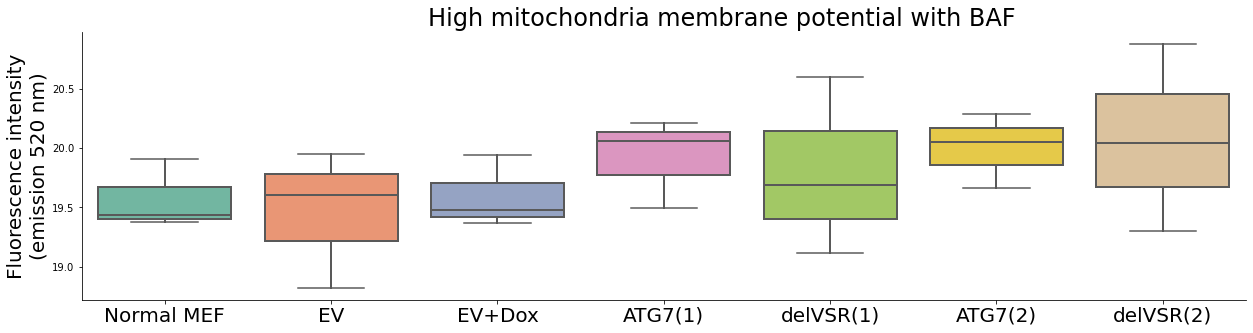

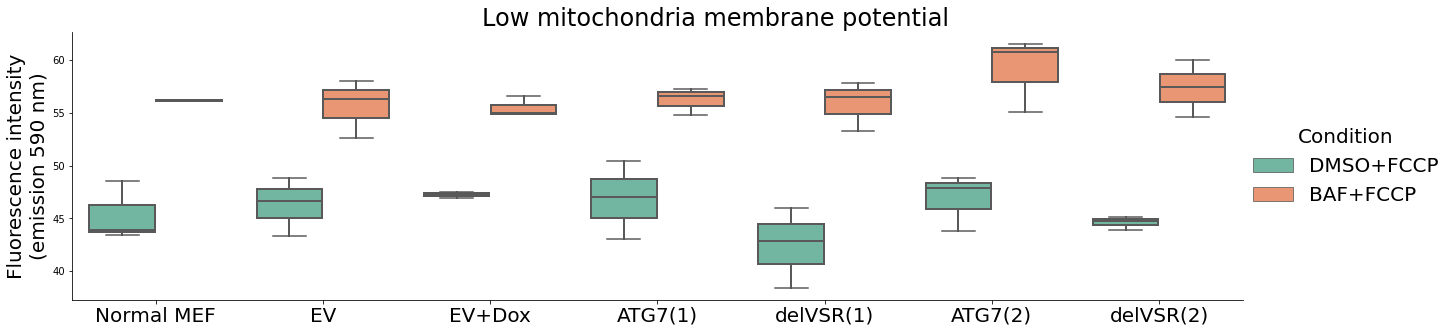

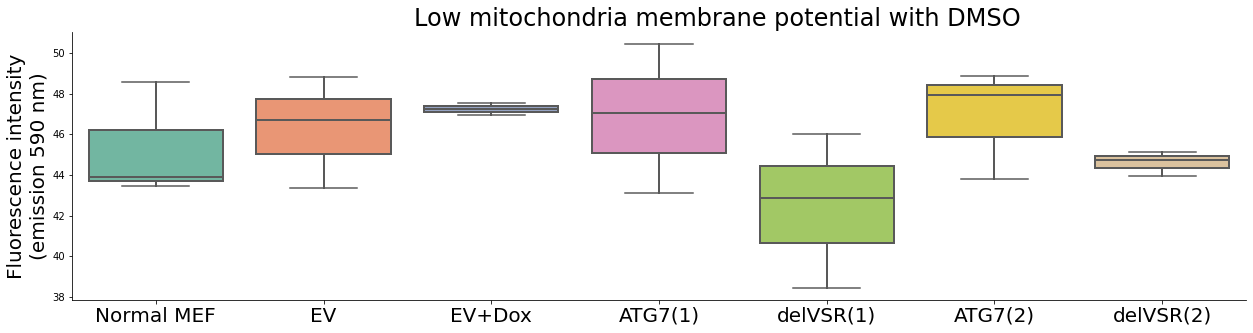

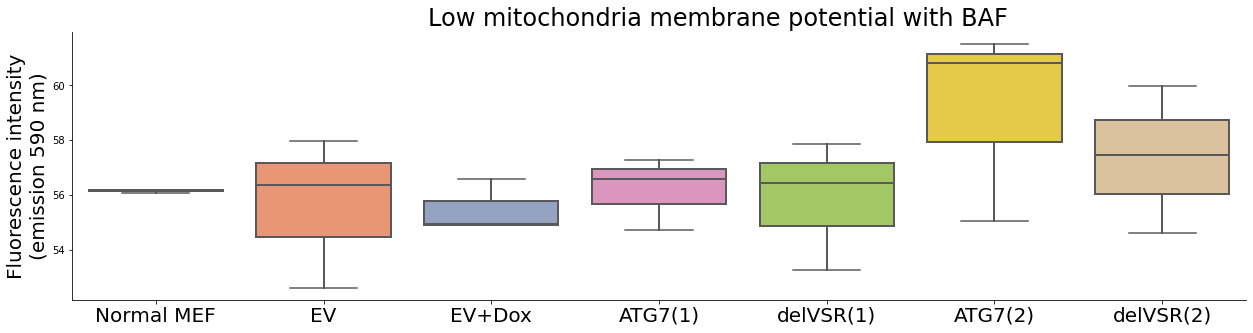

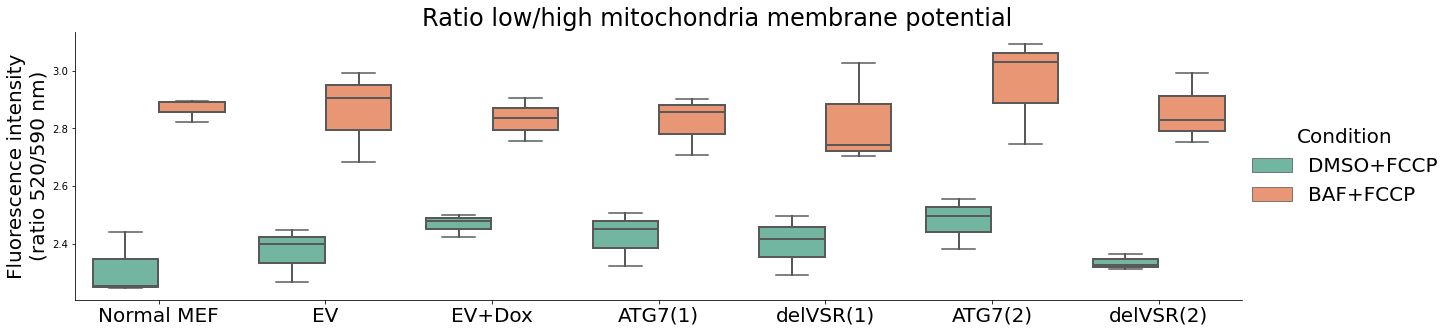

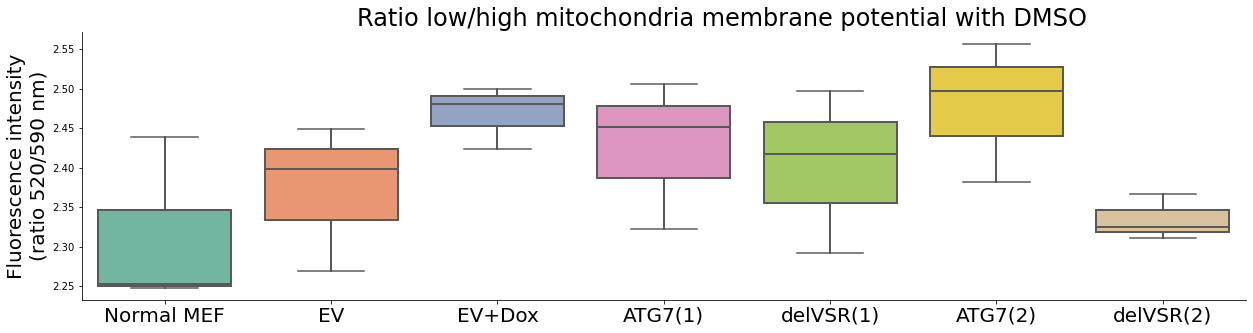

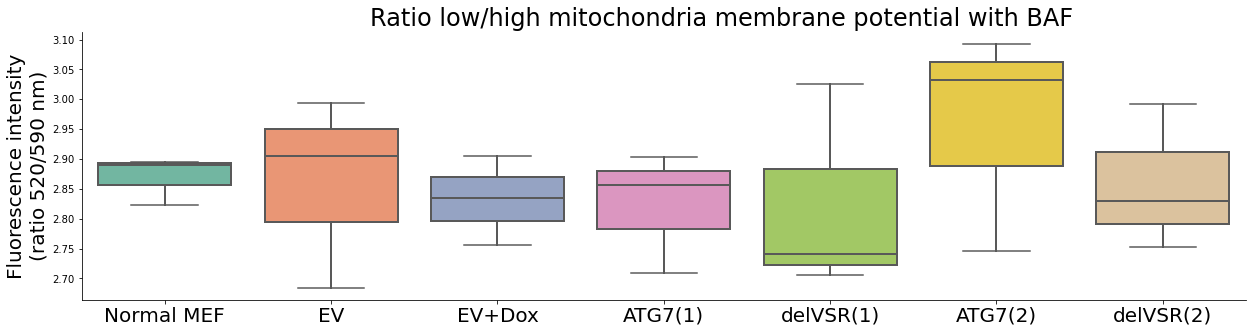

In [11]:
# Distribution: Data preparation + graph
all_data = [[df_aggregates, 'High mitochondria membrane potential', '(emission 520 nm)'],
             [df_monomeric, 'Low mitochondria membrane potential', '(emission 590 nm)'],
             [df_ratio, 'Ratio low/high mitochondria membrane potential', '(ratio 520/590 nm)']]

for data_ in all_data:
    Data = data_[0]
    info = data_[1]
    info_fluo = data_[2]
    
    shape = Data.shape
    shape = shape[0]
#     print(shape)

    #select the sample type column
    media_condition = {'condition':[Data.iloc[:,0][i]
      for i in range(0, shape)]}

    #convert to df, and copy it 3 times
    media_conditiondf = pandas.DataFrame(media_condition)
    media_conditiondf = pandas.concat([media_conditiondf,media_conditiondf,media_conditiondf,
                                      media_conditiondf,media_conditiondf,media_conditiondf,
                                      media_conditiondf])

    media_conditiondf.reset_index(drop=True, inplace=True)

    # Y for expression value 
    y = {'y':[Data.iloc[:,j][i]
      for j in range(1,8)
        for i in range(0, shape)]}

    #create df with Y 
    data_distrib = pandas.DataFrame(y).astype(float)

    # X for ATG7/iso1/iso2                              
    data_distrib.loc[:shape,'x'] = 'Normal MEF'
    data_distrib.loc[shape: shape*2,'x'] = 'EV'
    data_distrib.loc[shape*2: shape*3,'x'] = 'EV+Dox'
    data_distrib.loc[shape*3: shape*4,'x'] = 'ATG7(1)'
    data_distrib.loc[shape*4: shape*5,'x'] = 'delVSR(1)'
    data_distrib.loc[shape*5: shape*6,'x'] = 'ATG7(2)'
    data_distrib.loc[shape*6:,'x'] = 'delVSR(2)'

    # Will be used for Hue
    data_distrib['Condition'] = media_conditiondf['condition']
    
    #graph to see BAF + DMSO in the same graph. Useful to see BAF effect
    seaborn.catplot(x="x", y="y", hue="Condition", aspect = 3.5, kind="box", palette = 'Set2', data = data_distrib, 
                  boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)

    plt.ylabel('Fluorescence intensity\n' + info_fluo)
    plt.xlabel('')
    plt.title(info, x=.55)
    print()

    #separation of DMSO and BAF
    df_dmso = data_distrib[data_distrib['Condition'].str.startswith('DMSO')]
    df2_baf = data_distrib[data_distrib['Condition'].str.startswith('BAF')]
    
    dfs_conditions = [[df_dmso, ' with DMSO'], [df2_baf, ' with BAF']]
    for df_ in dfs_conditions:
        data_drug = df_[0]
        drug_info = df_[1]
    
        #graph with BAF or DMSO treatment separatly to have a better view of the cell lines
        seaborn.catplot(x="x", y="y", aspect = 3.5, kind="box", palette = 'Set2', data = data_drug,
                        boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)

        plt.ylabel('Fluorescence intensity\n' + info_fluo)
        plt.xlabel('')
        plt.title(info+drug_info, x=.55)
        print()

# print()


In [12]:
#Distribution: Stats for all 
all_data = [[df_ratio, 'Ratio low/high mitochondria membrane potential', '(ratio 520/590 nm)']]

column_name = df_aggregates.keys()
for data_ in all_data:
    Data = data_[0]
    info = data_[1]
    info_fluo = data_[2]  
    print(info)
    
    #separation of DMSO and BAF
    df_dmso = Data[Data['condition'].str.startswith('DMSO')]
    df2_baf = Data[Data['condition'].str.startswith('BAF')]

    dfs_conditions = [[df_dmso, 'with DMSO'], [df2_baf, 'with BAF']]
    for df_ in dfs_conditions:
        data_drug = df_[0]
        drug_info = df_[1]
        print(drug_info.upper())
        
        # Mann-Whitney analysis 
        #EV vs WT1
        statistic, pvalue = scipy.stats.mannwhitneyu(data_drug[column_name[3]], data_drug[column_name[4]])
        Pvalue = "{:.3E}".format(pvalue)
        print(column_name[3], "and", column_name[4], drug_info, 'pvalue is', Pvalue)
        
        #EV vs WT1
        statistic, pvalue = scipy.stats.mannwhitneyu(data_drug[column_name[3]], data_drug[column_name[6]])
        Pvalue = "{:.3E}".format(pvalue)
        print(column_name[3], "and", column_name[6], drug_info, 'pvalue is', Pvalue)
        
         #EV vs WT1
        statistic, pvalue = scipy.stats.mannwhitneyu(data_drug[column_name[4]], data_drug[column_name[6]])
        Pvalue = "{:.3E}".format(pvalue)
        print(column_name[4], "and", column_name[6], drug_info, 'pvalue is', Pvalue)
        print()

Ratio low/high mitochondria membrane potential
WITH DMSO
ev_dox and wt1 with DMSO pvalue is 5.000E-01
ev_dox and wt2 with DMSO pvalue is 5.000E-01
wt1 and wt2 with DMSO pvalue is 3.313E-01

WITH BAF
ev_dox and wt1 with BAF pvalue is 5.000E-01
ev_dox and wt2 with BAF pvalue is 3.313E-01
wt1 and wt2 with BAF pvalue is 1.914E-01



In [13]:
Data

,condition,normal,ev,ev_dox,wt1,vsr1,wt2,vsr2
0,DMSO+FCCP,2.43924,2.44842,2.48055,2.50621,2.49631,2.55609,2.32525
1,DMSO+FCCP,2.24804,2.26901,2.49989,2.3218,2.29176,2.38192,2.31093
2,DMSO+FCCP,2.25276,2.39854,2.42407,2.45068,2.41773,2.49734,2.36622
3,BAF+FCCP,2.82282,2.90562,2.83522,2.90366,3.02631,3.03205,2.99267
4,BAF+FCCP,2.89497,2.99368,2.90528,2.85573,2.74139,3.09221,2.82979
5,BAF+FCCP,2.89056,2.68469,2.75623,2.70848,2.70535,2.74592,2.75257
